# **Pneumonia Detection**

For image classification,convolution neural network (CNN) is applied for deep learning as these complex problem requires to learn features automatically from the data. The convolutional neural networks not only performs better on high dimension dataset but is efficient on very little data to learn from. The convolution neural network is trained from strach on 20% of the large image dataset due to computational limitations. This dataset consist of chest X-Ray images to be classified as either ’normal’ or ’pneumonia’. These Images are Jpeg format.

####  Following Task are performed in the notebook for different model and its evaluation. 

Task 1 - Data loading and exploration <br /> 
Task 2 - Logistic regression model <br />
Task 3 - LeNet-5 CNN <br />
Task 4 - LeNet-5 Data augmentation <br />
Task 5 - Pre-trained VGG16 model <br />
Task 6 - Reflection <br />

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import random
import warnings
import os
import copy

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import scikitplot as skplt

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.utils.vis_utils import model_to_dot
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, load_img

import cv2
import tensorflow as tf


import matplotlib.pyplot as plt
%matplotlib inline 
from PIL import Image
import scipy as sp

import matplotlib.image as mpimg
import seaborn as sns

np.random.seed(1337)
keras.backend.set_image_data_format('channels_last')

Using TensorFlow backend.


In [2]:
warnings.filterwarnings("ignore")

# Task 1  - Data loading and exploration <br />  

In order to  perform data classification,we need to perform initial data exploration on Image dataset and load it.The dataset is having into 2 folders (train, test) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).
    
- Load data 
- Due to computational limitation, we consider only the 20% of data and load it into array.
- Sampling 
- Normalization
- Reshape
- Label encoding 
- Split training and valdiation set

In [3]:
def load_data_from_folders(data_dir, class_folders, sample_rate):
    
    #Initialise arrays for data storage
    X_data_color = np.ndarray((0, input_shape_color[0], input_shape_color[1],
                               input_shape_color[2]), dtype=np.float)
    X_data_gray = np.ndarray((0, input_shape_gray[0], input_shape_gray[1],
                              input_shape_gray[2]), dtype=np.float)
    y_data = np.ndarray(0, dtype=np.str)
    
    # Loop through the class folders
    for i, image_cls in enumerate(class_folders):

        print('Processing class {}'.format(image_cls))
        image_class_folder = data_dir + image_cls +"/"

        # generate filenames from the data folder and do sampling
        image_filenames = [image_class_folder+ i for i in os.listdir(image_class_folder) if not i.startswith('.')] # use this for full dataset
        image_filenames = random.sample(image_filenames, int(len(image_filenames)*sample_rate))
        
        # Create a data array for image data
        count = len(image_filenames)
        X_data_part_color = np.ndarray((count, input_shape_color[0], input_shape_color[1],
                                        input_shape_color[2]), dtype=np.float)
        X_data_part_gray = np.ndarray((count, input_shape_gray[0], input_shape_gray[1],
                                        input_shape_gray[2]), dtype=np.float)

        # Iterate throuigh the filenames and for each one load the image, resize and normalise
        for i, image_file in enumerate(image_filenames):
            # Load the color images and resize them
            image = cv2.imread(image_file, cv2.IMREAD_COLOR)
            image_color = cv2.resize(image, (img_height, img_width), interpolation=cv2.INTER_CUBIC)
            image_color = image_color[:,:,[2,1,0]]
            
            # Load the gray images and resize them
            image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image_gray = cv2.resize(image_gray, (img_height, img_width), interpolation=cv2.INTER_CUBIC)
            image_gray = np.asarray(image_gray).reshape(image_gray.shape[0],image_gray.shape[1],1)
            
            
            # Add image data to data array and normalise
            X_data_part_color[i] = image_color
            X_data_part_color[i] = X_data_part_color[i]/255
            
            X_data_part_gray[i] = image_gray
            X_data_part_gray[i] = X_data_part_gray[i]/255

            # Add label to label array
            y_data = np.append(y_data, image_cls)

            if i%100 == 0: print('Processed {} of {} for class {} '.format(i, count, image_cls))

        print('Processed {} of {} for class {} '.format(i + 1, count, image_cls))

        # Append the part to the overall data array
        X_data_color = np.append(X_data_color, X_data_part_color, axis=0)
        X_data_gray = np.append(X_data_gray, X_data_part_gray, axis=0)
        
    return X_data_color, X_data_gray, y_data

Setting the image dimensions to 162*128

In [4]:
img_width, img_height = 162, 128

if K.image_data_format() == 'channels_first':
    input_shape_color = (3, img_width, img_height)
    input_shape_gray = (1, img_width, img_height)
else:
    input_shape_color = (img_width, img_height, 3)
    input_shape_gray = (img_width, img_height, 1)


For this task we are considering twenty percent of data from the full dataset. 

Data is loaded in color and grayscale as seperate datasets and the grayscale data is divided into train and validate sets. The test set is loaded from the test directory.

In [5]:
train_data_dir = './data_chest_xray/train/'
test_data_dir = './data_chest_xray/test/'
sample_rate = 0.20

print('Loading train folder:')
training_class_folders = [i for i in os.listdir(train_data_dir) if not i.startswith('.')]
num_classes = len(training_class_folders)

X_train, X_gray, y_train = load_data_from_folders(train_data_dir, training_class_folders, sample_rate)

# Perfrom split to train, validation, test for color
X_train_color, X_valid_color, y_train_color, y_valid_color = train_test_split(X_train, y_train, random_state=0,
                                                      stratify = y_train, test_size = 0.20, train_size = 0.8)
y_train_color
# Perfrom split to train, validation, test for gray
X_train_gray, X_valid_gray, y_train_gray, y_valid_gray = train_test_split(X_gray, y_train, random_state=0,
                                                      stratify = y_train, test_size = 0.20, train_size = 0.8)
print("*" * 40)

print('Loading test folder:')
test_class_folders = [i for i in os.listdir(test_data_dir) if not i.startswith('.')]
X_test_color, X_test_gray, y_test = load_data_from_folders(test_data_dir, test_class_folders, sample_rate)


Loading train folder:
Processing class PNEUMONIA
Processed 0 of 776 for class PNEUMONIA 
Processed 100 of 776 for class PNEUMONIA 
Processed 200 of 776 for class PNEUMONIA 
Processed 300 of 776 for class PNEUMONIA 
Processed 400 of 776 for class PNEUMONIA 
Processed 500 of 776 for class PNEUMONIA 
Processed 600 of 776 for class PNEUMONIA 
Processed 700 of 776 for class PNEUMONIA 
Processed 776 of 776 for class PNEUMONIA 
Processing class NORMAL
Processed 0 of 269 for class NORMAL 
Processed 100 of 269 for class NORMAL 
Processed 200 of 269 for class NORMAL 
Processed 269 of 269 for class NORMAL 
****************************************
Loading test folder:
Processing class PNEUMONIA
Processed 0 of 78 for class PNEUMONIA 
Processed 78 of 78 for class PNEUMONIA 
Processing class NORMAL
Processed 0 of 46 for class NORMAL 
Processed 46 of 46 for class NORMAL 


Dataset shapes for color data

In [6]:
print("Data shape for the color train dataset: {}".format(X_train_color.shape))
print("Data shape for the color valid dataset: {}".format(X_valid_color.shape))

Data shape for the color train dataset: (836, 162, 128, 3)
Data shape for the color valid dataset: (209, 162, 128, 3)


Dataset shapes for gray data

In [7]:
print("Data shape for train gray set: {}".format(X_train_gray.shape))
print("Data shape for valid gray set: {}".format(X_valid_gray.shape))

Data shape for train gray set: (836, 162, 128, 1)
Data shape for valid gray set: (209, 162, 128, 1)


In [8]:
print("Data shape for test: {}".format(X_test_color.shape))
print("Data shape for test: {}".format(X_test_gray.shape))

Data shape for test: (124, 162, 128, 3)
Data shape for test: (124, 162, 128, 1)


### Class Distibutions in train dataset

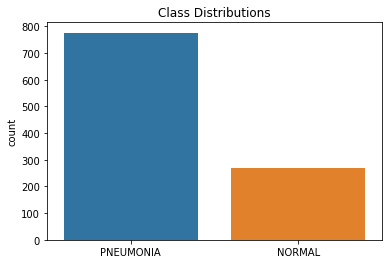

In [9]:
distribution = sns.countplot(y_train).set_title('Class Distributions')

 The dataset is very biased in which PNEUMONIA has almost thrice the number of records as NORMAL

### Sample images from the dataset

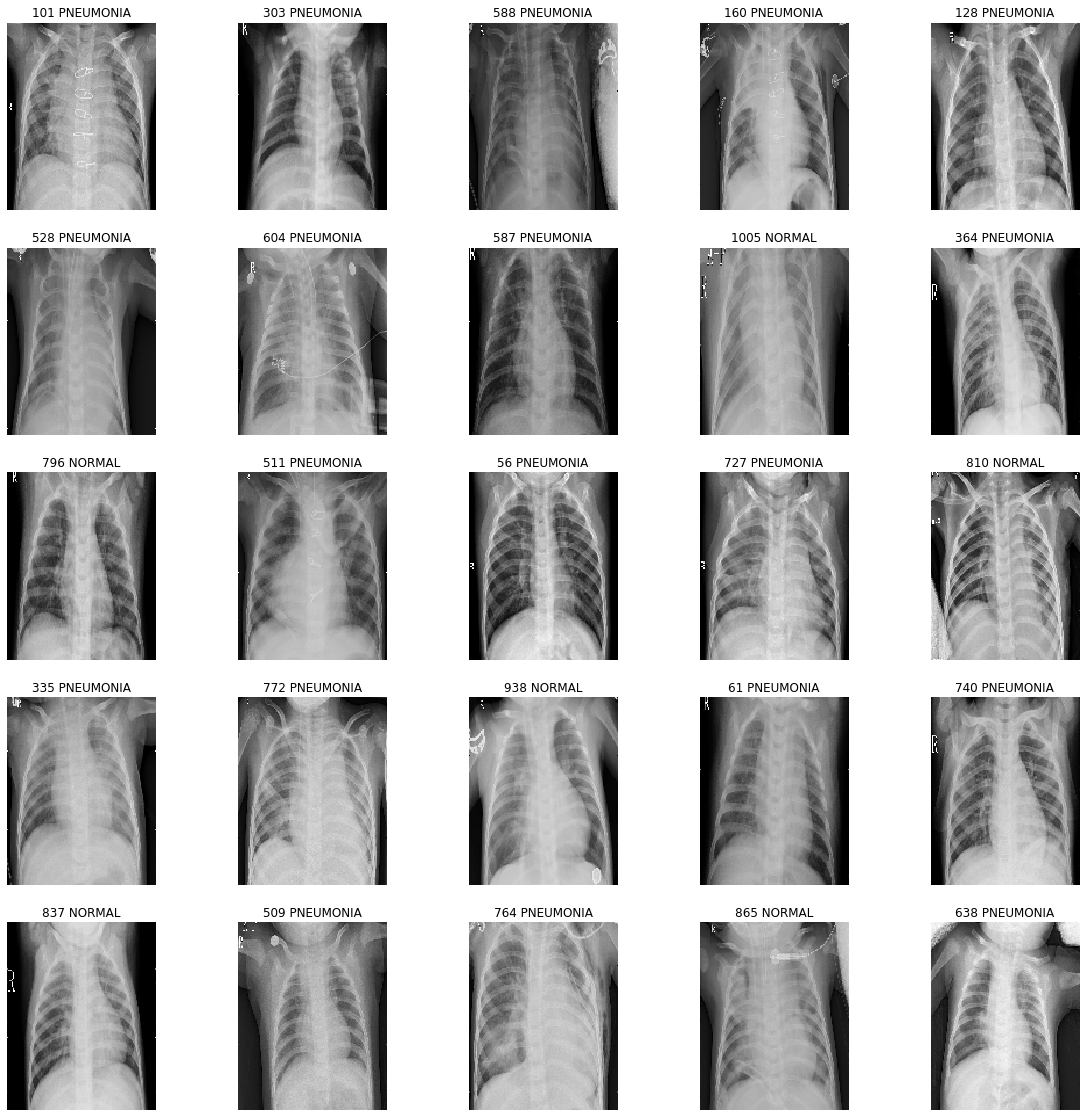

In [10]:
row_images = 5
col_images = 5

plt.figure(figsize=(20, 20))

for i in range(row_images * col_images):
    i_rand = random.randint(0, X_train.shape[0])
    plt.subplot(row_images,col_images,i+1)
    plt.axis('off')
    plt.imshow(sp.misc.toimage(X_train[i]))
    plt.title((str(i_rand) + " " + y_train[i_rand]))
plt.show()

 The Images shown above are sample image for Chest X-Rays in patients with pneumonia, Normal. The Normal chest X-ray  has clear lungs without an area of increased attenuation in the image whereas Pneumonia Chest Xrays has opacification of lung.

### Reshaping output data for use with a neural network

In [11]:
# Convert class vectors to binary class matrices.
y_train_encoder = LabelEncoder()

# y_train for color
y_train_color_num = y_train_encoder.fit_transform(y_train_color)
y_train_color_wide = keras.utils.to_categorical(y_train_color_num, num_classes)

# y_valid for color
y_valid_color_num = y_train_encoder.fit_transform(y_valid_color)
y_valid_color_wide = keras.utils.to_categorical(y_valid_color_num, num_classes)


# y_train for gray
y_train_gray_num = y_train_encoder.fit_transform(y_train_gray)
y_train_gray_wide = keras.utils.to_categorical(y_train_gray_num, num_classes)

# y_valid for gray
y_valid_gray_num = y_train_encoder.fit_transform(y_valid_gray)
y_valid_gray_wide = keras.utils.to_categorical(y_valid_gray_num, num_classes)

# y_test
y_test_num = y_train_encoder.fit_transform(y_test)
y_test_wide = keras.utils.to_categorical(y_test_num, num_classes)

### Record the number to label mapping 

In [12]:
classes_num_label = dict()

for idx, lbl in enumerate(y_train_encoder.classes_):
    classes_num_label[idx] = lbl
    
print(classes_num_label)

{0: 'NORMAL', 1: 'PNEUMONIA'}


# Task 2 - Modeling with Logistic Regression

### Reshaping data into single stream

In [13]:
# reshaping train dataset
nsamples, nx, ny, nz = X_train_gray.shape
reshaped_X_train_gray = X_train_gray.reshape((nsamples, nx*ny*nz))

# reshaping valid dataset
nsamples, nx, ny, nz = X_valid_gray.shape
reshaped_X_valid_gray = X_valid_gray.reshape((nsamples, nx*ny*nz))

# reshaping test dataset
nsamples, nx, ny, nz = X_test_gray.shape
reshaped_X_test_gray = X_test_gray.reshape((nsamples, nx*ny*nz))

In [14]:
lr_model = LogisticRegression(random_state=0).fit(reshaped_X_train_gray, y_train_gray)

### Evaluating Logistic regression model on validation set

              precision    recall  f1-score   support

      NORMAL       0.94      0.85      0.89        54
   PNEUMONIA       0.95      0.98      0.97       155

    accuracy                           0.95       209
   macro avg       0.94      0.92      0.93       209
weighted avg       0.95      0.95      0.95       209

************************************************************


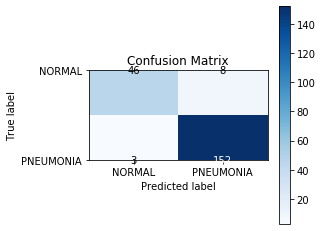

In [15]:
# Make a set of predictions for the test data
lr_pred_valid = lr_model.predict(reshaped_X_valid_gray)

# Print performance details
print(metrics.classification_report(y_valid_gray, lr_pred_valid))
lr_pred_valid_acc= round(metrics.classification_report(y_valid_gray, lr_pred_valid,
                                                 output_dict=True)['accuracy'],2)
print("*" * 60)
skplt.metrics.plot_confusion_matrix(y_valid_gray, lr_pred_valid, figsize=(4,4))
plt.show()

The Logistic regression model accuracy seems to perform decent on validation data with accuracy of 0.95. Also, we observe that F1 score for Pneumonia are 0.92 and 0.97 respectively which is very good.

# Task 3 - Modeling with CNN
The image classification task deal with complex image and large variety of data exist. CNN are used break through in image classification and are widely used.


### LeNet-5 Architecture
The LeNet-5 architecture consists of two sets of convolutional and max pooling layers, followed by a flattening convolutional layer, then two fully-connected layers and finally a softmax classifier. (Source: https://engmrk.com/lenet-5-a-classic-cnn-architecture/)
                            
First layer: The input for LeNet-5 is a 162*128 grayscale image which passes through the first convolutional layer with 6 feature maps or filters having size 5×5 and a stride of one.

Second layer: Then the LeNet-5 applies average pooling layer or sub-sampling layer with a filter size 2×2 and a stride of two.

Finally, there are two fully connected layers and an activation layer with softmax activation. 

In [17]:
# initialize the model
leNet5_model = Sequential()

# First set of conv, activation and pool layers
leNet5_model.add(Conv2D(filters=6, kernel_size=(5,5), padding="same",
                input_shape=input_shape_gray))
leNet5_model.add(Activation('relu'))
leNet5_model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2)))

# Second set of conv, activation and pool layers
leNet5_model.add(Conv2D(filters=16, kernel_size=(5, 5), padding="same"))
leNet5_model.add(Activation('relu'))
leNet5_model.add(MaxPooling2D(pool_size=(2, 2) ,strides = (2,2)))

# Fully conneted layers
leNet5_model.add(Flatten())
leNet5_model.add(Dense(120))
leNet5_model.add(Activation('relu'))

leNet5_model.add(Dropout(0.5))
leNet5_model.add(Dense(84, activation='relu'))

leNet5_model.add(Dense(num_classes))

leNet5_model.add(Activation('softmax'))

In [18]:
leNet5_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

leNet5_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 162, 128, 6)       156       
_________________________________________________________________
activation_1 (Activation)    (None, 162, 128, 6)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 81, 64, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 81, 64, 16)        2416      
_________________________________________________________________
activation_2 (Activation)    (None, 81, 64, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 40, 32, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 20480)            

Saving a copy of LeNet5 model for future use.

In [19]:
copy_leNet5_model = copy.deepcopy(leNet5_model)

Training the model using grayscale images with batch size of 128 and epoch of 10. <br /> We allow the model to overfit but save the best set of weights based on validation loss as we go. Then at the end of training (assuming the model has overfit) we revert back to the saved model.

In [20]:
batch_size = 128
epochs = 10

# Set up the callback to save the best model based on validaion data
best_weights_filepath = './best_weights_notebook1.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_loss",
                      save_best_only=True, save_weights_only=False)

history = leNet5_model.fit(X_train_gray, y_train_gray_wide,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          validation_data=(X_valid_gray, y_valid_gray_wide),
          shuffle=True,
          callbacks=[mcp])


Train on 836 samples, validate on 209 samples
Epoch 1/10
836/836 [==============================] - 5s 6ms/step - loss: 0.6018 - accuracy: 0.6926 - val_loss: 0.5244 - val_accuracy: 0.7416
Epoch 2/10
836/836 [==============================] - 4s 5ms/step - loss: 0.4656 - accuracy: 0.7859 - val_loss: 0.3865 - val_accuracy: 0.7990
Epoch 3/10
836/836 [==============================] - 4s 5ms/step - loss: 0.3470 - accuracy: 0.8565 - val_loss: 0.2932 - val_accuracy: 0.8660
Epoch 4/10
836/836 [==============================] - 4s 5ms/step - loss: 0.2634 - accuracy: 0.8947 - val_loss: 0.2539 - val_accuracy: 0.8852
Epoch 5/10
836/836 [==============================] - 4s 5ms/step - loss: 0.2246 - accuracy: 0.9043 - val_loss: 0.2970 - val_accuracy: 0.8756
Epoch 6/10
836/836 [==============================] - 4s 5ms/step - loss: 0.2226 - accuracy: 0.8935 - val_loss: 0.2640 - val_accuracy: 0.8900
Epoch 7/10
836/836 [==============================] - 4s 5ms/step - loss: 0.1929 - accuracy: 0.9199 - 

Reload best weights into the model

In [21]:
leNet5_model.load_weights(best_weights_filepath)

### Plotting some evaluation statistics

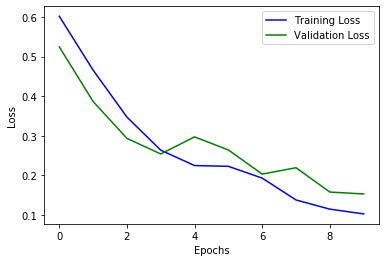

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

### Evaluating LeNet-5 CNN on validation dataset

              precision    recall  f1-score   support

           0       0.94      0.85      0.89        54
           1       0.95      0.98      0.97       155

    accuracy                           0.95       209
   macro avg       0.94      0.92      0.93       209
weighted avg       0.95      0.95      0.95       209

Confusion matrix
************************************************************


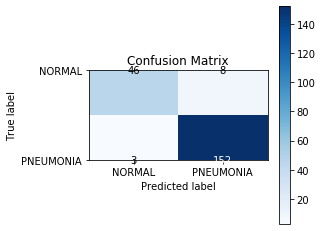

In [23]:
# Make a set of predictions for the training data
leNet5_pred_valid = leNet5_model.predict_classes(X_valid_gray)

# Print performance details
print(metrics.classification_report(y_valid_gray_num, leNet5_pred_valid))
leNet5_pred_valid_acc= round(metrics.classification_report(y_valid_gray_num, leNet5_pred_valid,
                                                 output_dict=True)['accuracy'], 2)
print("Confusion matrix")
print("*" * 60)
skplt.metrics.plot_confusion_matrix(list(map(lambda x: classes_num_label[x], y_valid_gray_num)),
                                    list(map(lambda x: classes_num_label[x], leNet5_pred_valid)),
                                    figsize=(4,4))
plt.show()

The LeNet-5 CNN model accuracy seems to perform decent on validation data with accuracy of 0.95. Also, we observe that f1 score for Pneumonia are 0.89 and 0.97 respectively which is pretty good.

## Handling imbalance on the dataset

The the dataset we are working on is highly biased towards Pneumonia. Hence the balance the dataset we are undersampling this class to match the count of class Normal.

In [24]:
df = pd.DataFrame(data = y_train_gray_num)

count_class_1, count_class_0 = df[0].value_counts()

# Divide by class
df_class_0 = df[df[0] == 0]
df_class_1 = df[df[0] == 1]

df_class_1_under = df_class_1.sample(count_class_0)

class_1_undersampled_indices = df_class_1_under.index.values
class_0_indices = df_class_0.index.values

X_train_gray_undersampled = list()
y_train_num_undersampled = list()

for val in class_1_undersampled_indices:
    X_train_gray_undersampled.append(X_train_gray[val])
    y_train_num_undersampled.append(y_train_gray_num[val])
    
for val in class_0_indices:
    X_train_gray_undersampled.append(X_train_gray[val])
    y_train_num_undersampled.append(y_train_gray_num[val])

X_train_gray_undersampled = np.array(X_train_gray_undersampled)
y_train_num_undersampled = np.array(y_train_num_undersampled)

In [25]:
y_train_wide_undersampled = keras.utils.to_categorical(y_train_num_undersampled, num_classes)

Copying the LeNet5 model.

In [26]:
leNet5_model_undersamp = copy.deepcopy(copy_leNet5_model)

Training the model using grayscale images. <br /> We allow the model to overfit but save the best set of weights based on validation loss as we go. Then at the end of training (assuming the model has overfit) we revert back to the saved model.

In [27]:
batch_size = 128
epochs = 10

# Set up the callback to save the best model based on validaion data
best_weights_filepath = './best_weights_notebook2.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_loss",
                      save_best_only=True, save_weights_only=False)

history = leNet5_model_undersamp.fit(X_train_gray_undersampled, y_train_wide_undersampled,
          batch_size=batch_size, epochs=epochs, verbose = 1,
          validation_data=(X_valid_gray, y_valid_gray_wide),
          shuffle=True, callbacks=[mcp])


Train on 430 samples, validate on 209 samples
Epoch 1/10
430/430 [==============================] - 2s 5ms/step - loss: 0.6922 - accuracy: 0.5140 - val_loss: 0.6540 - val_accuracy: 0.7177
Epoch 2/10
430/430 [==============================] - 2s 5ms/step - loss: 0.6273 - accuracy: 0.6837 - val_loss: 0.6176 - val_accuracy: 0.6938
Epoch 3/10
430/430 [==============================] - 2s 5ms/step - loss: 0.4996 - accuracy: 0.8767 - val_loss: 0.4448 - val_accuracy: 0.8565
Epoch 4/10
430/430 [==============================] - 2s 5ms/step - loss: 0.3786 - accuracy: 0.8698 - val_loss: 0.3062 - val_accuracy: 0.8708
Epoch 5/10
430/430 [==============================] - 2s 5ms/step - loss: 0.2981 - accuracy: 0.8930 - val_loss: 0.6679 - val_accuracy: 0.7512
Epoch 6/10
430/430 [==============================] - 2s 5ms/step - loss: 0.2634 - accuracy: 0.9116 - val_loss: 0.2445 - val_accuracy: 0.8947
Epoch 7/10
430/430 [==============================] - 2s 5ms/step - loss: 0.2098 - accuracy: 0.9186 - 

In [28]:
#reload best weights
leNet5_model_undersamp.load_weights(best_weights_filepath)

### Plotting some evaluation statistics

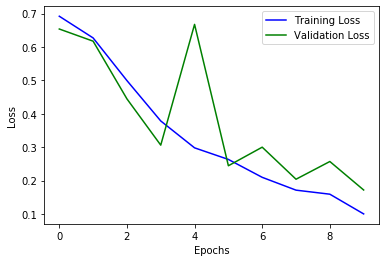

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

### Evaluating LeNet-5 CNN with validation data

              precision    recall  f1-score   support

           0       0.84      0.87      0.85        54
           1       0.95      0.94      0.95       155

    accuracy                           0.92       209
   macro avg       0.90      0.91      0.90       209
weighted avg       0.92      0.92      0.92       209

************************************************************


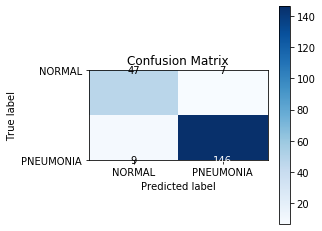

In [30]:
# Make a set of predictions for the test data
leNet5_model_undersamp_pred = leNet5_model_undersamp.predict_classes(X_valid_gray)

# Print performance details
print(metrics.classification_report(y_valid_gray_num, leNet5_model_undersamp_pred))
leNet5_model_undersamp_pred_acc= round(metrics.classification_report(y_valid_gray_num,
                                                                     leNet5_model_undersamp_pred,
                                                 output_dict=True)['accuracy'], 2)
print("*" * 60)
skplt.metrics.plot_confusion_matrix(list(map(lambda x: classes_num_label[x], y_valid_gray_num)),
                                    list(map(lambda x: classes_num_label[x], leNet5_model_undersamp_pred)),
                                    figsize=(4,4))
plt.show()

The LeNet-5 CNN model accuracy does not seem to perform better than the latter when the dataset is balanced, but is decent with accuracy of 0.92. Also, we observe that f1 score for Pneumonia are 0.85 and 0.95 respectively. Even here the classification for Pneumonia is better than that of Normal.

# Task 4 - Data Augmentation

Data augmentation is a technique that helps to increase the diversity of data available for training models, without actually collecting new data. The most commonly used data augmentation techniques are as zooming, cropping, padding, and horizontal flipping.

### Sample augmentation of some images

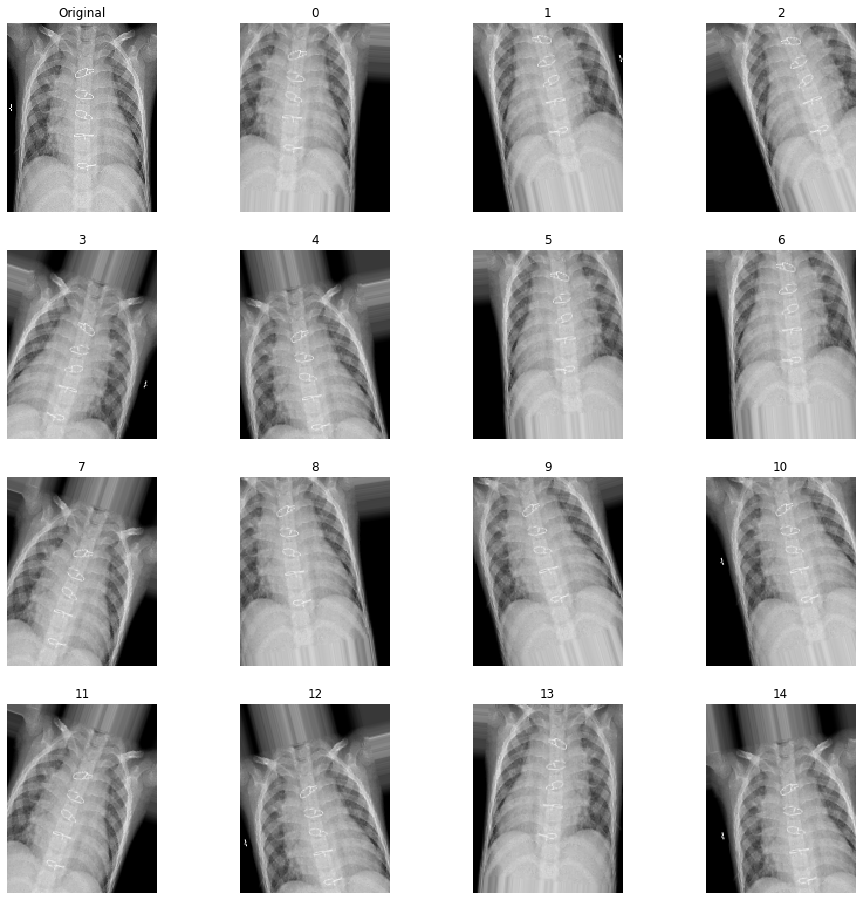

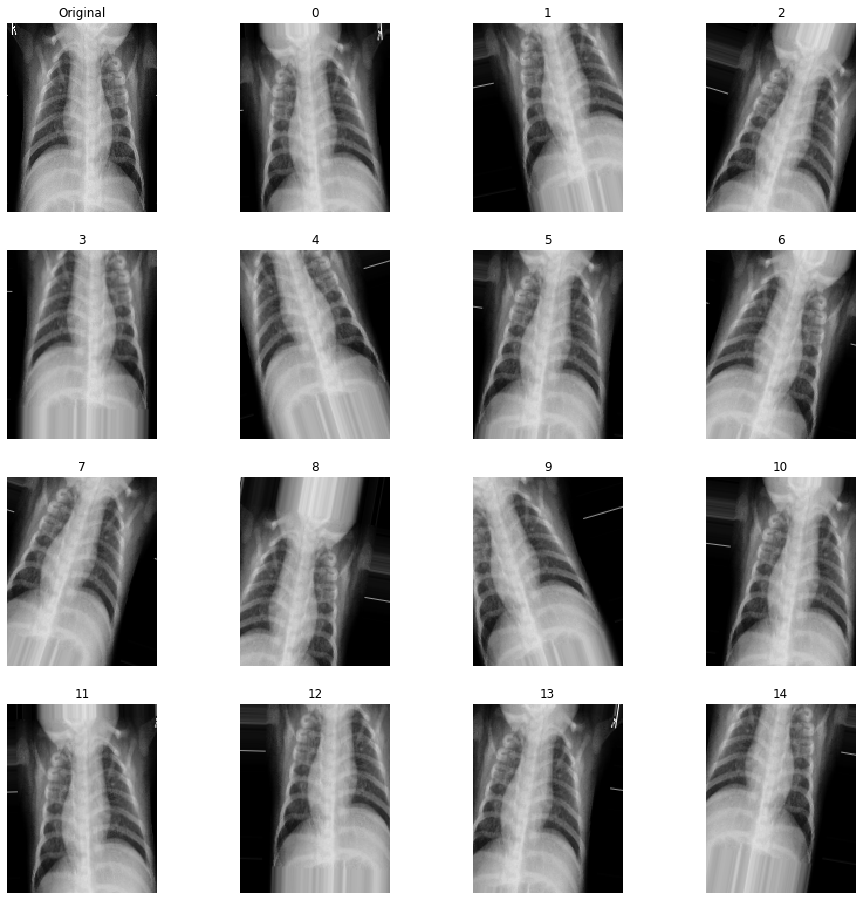

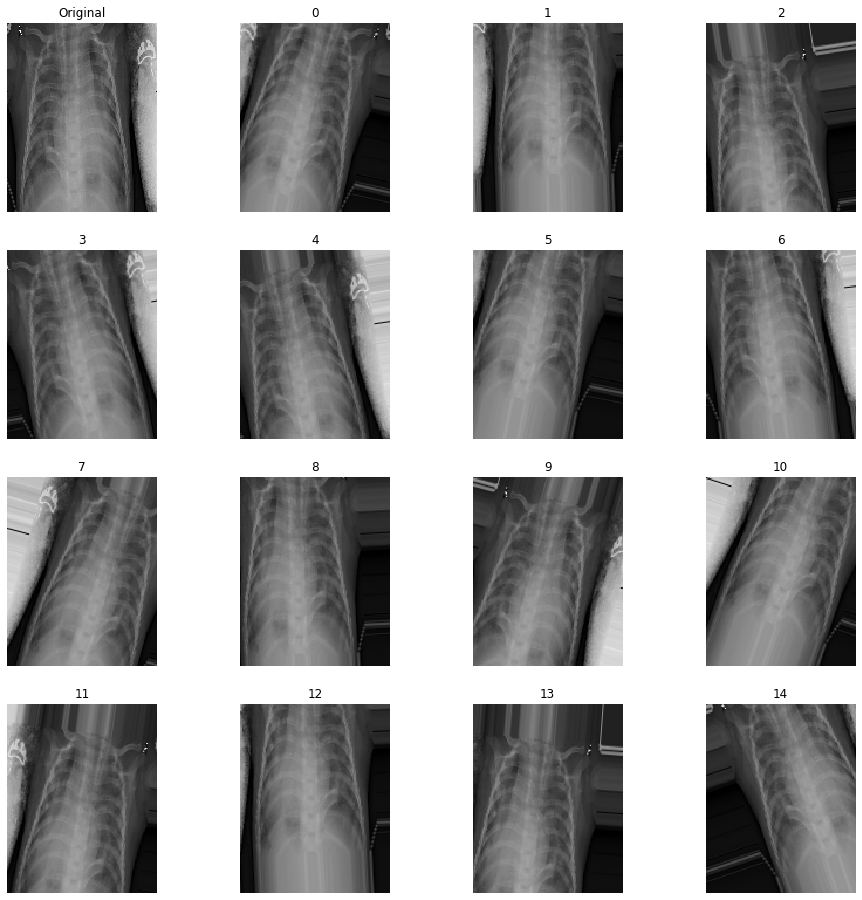

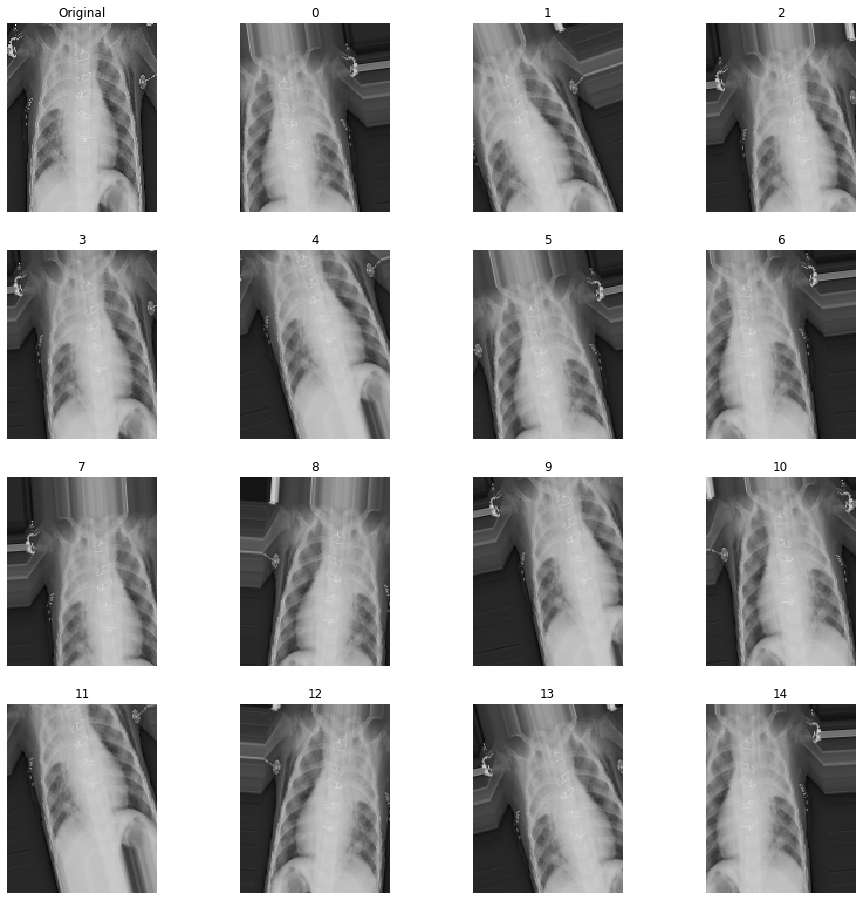

In [31]:
pltsize=4
row_images = 4
col_images = 4

# Create a transformed data generator
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

# fit parameters from data
datagen.fit(X_train)

for idx in range(0, 4):
    # Plotting the original image
    plt.figure(figsize=(col_images*pltsize, row_images*pltsize))
    plt.subplot(row_images,col_images,1)
    plt.axis('off')
    plt.imshow(X_train[idx])
    plt.title("Original")
    # Plotting the augmented image
    for i in range(row_images * col_images - 1):
        rand_trans = datagen.random_transform(X_train[idx])
        plt.subplot(row_images,col_images,i+2)
        plt.axis('off')
        plt.imshow(rand_trans)
        plt.title(i)

    plt.show() 

In [32]:
leNet5_model_aug = copy.deepcopy(copy_leNet5_model)

### Training the model using on the fly data augmentation.

The augmentation techniques used for chest x-ray are width shift, height shift, brightness and zoom.

In [33]:
batch_size = 128
epochs = 10

# Set up the callback to save the best model based on validaion data
best_weights_filepath = './best_weights_notebook3.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_loss",
                      save_best_only=True, save_weights_only=False)

# Create a data generator for the trianing data
datagen_train = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.5,1],
    zoom_range=[0.8,1.3])

datagen_train.fit(X_train_gray)

history = leNet5_model_aug.fit_generator(
    datagen_train.flow(X_train_gray, y_train_gray_wide, batch_size=batch_size),
    steps_per_epoch=len(X_train_gray) / batch_size,
    validation_data= (X_valid_gray, y_valid_gray_wide),
    epochs=epochs, verbose = 1, shuffle=True,
    callbacks=[mcp])


Epoch 1/10
7/6 [================================] - 4s 595ms/step - loss: 0.6713 - accuracy: 0.7105 - val_loss: 0.6400 - val_accuracy: 0.7416
Epoch 2/10
7/6 [================================] - 4s 546ms/step - loss: 0.6150 - accuracy: 0.7368 - val_loss: 0.5991 - val_accuracy: 0.7416
Epoch 3/10
7/6 [================================] - 4s 556ms/step - loss: 0.5915 - accuracy: 0.7428 - val_loss: 0.5789 - val_accuracy: 0.7416
Epoch 4/10
7/6 [================================] - 4s 543ms/step - loss: 0.5854 - accuracy: 0.7428 - val_loss: 0.5503 - val_accuracy: 0.7416
Epoch 5/10
7/6 [================================] - 4s 548ms/step - loss: 0.5637 - accuracy: 0.7428 - val_loss: 0.5279 - val_accuracy: 0.7416
Epoch 6/10
7/6 [================================] - 4s 572ms/step - loss: 0.5445 - accuracy: 0.7440 - val_loss: 0.4551 - val_accuracy: 0.7416
Epoch 7/10
7/6 [================================] - 4s 537ms/step - loss: 0.5082 - accuracy: 0.7428 - val_loss: 0.4302 - val_accuracy: 0.7416
Epoch 

In [34]:
#reload best weights
leNet5_model_aug.load_weights(best_weights_filepath)

### Plotting some evaluation statistics

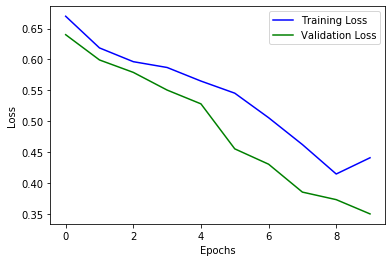

In [35]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

### Evaluating LeNet-5 CNN with data augumentation on validation set

              precision    recall  f1-score   support

           0       0.67      0.83      0.74        54
           1       0.94      0.86      0.90       155

    accuracy                           0.85       209
   macro avg       0.80      0.85      0.82       209
weighted avg       0.87      0.85      0.86       209

************************************************************


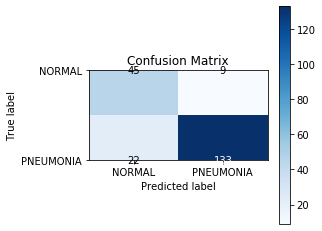

In [36]:
# Make a set of predictions for the test data
leNet5_pred_aug_valid = leNet5_model_aug.predict_classes(X_valid_gray)

# Print performance details
print(metrics.classification_report(y_valid_gray_num, leNet5_pred_aug_valid))
leNet5_pred_aug_valid_acc = round(metrics.classification_report(y_valid_gray_num,
                                                                leNet5_pred_aug_valid,
                                                 output_dict=True)['accuracy'], 2)
print("*" * 60)
skplt.metrics.plot_confusion_matrix( list(map(lambda x: classes_num_label[x], y_valid_gray_num)),
                                    list(map(lambda x: classes_num_label[x], leNet5_pred_aug_valid)),
                                    figsize=(4,4))
plt.show()

The LeNet-5 CNN model when trained with additional augmented images accuracy do not perform better than the latter and has an accuracy of 0.85. Further, we observe that f1 score for Pneumonia is 0.90 but the score for Normal is quite low at 0.74.

# Task 5 - VGG16 Model
VGG16 is a convolutional neural network model and is considered to be one of the best vision models which achieves 92.7% top-5 test accuracy in ImageNet. Most unique thing about VGG16 is that instead of having a large number of hyper-parameter they focused on having convolution layers of 3x3 filter with a stride 1 and always used same padding and maxpool layer of 2x2 filter of stride 2. It follows this arrangement of convolution and max pool layers consistently throughout the whole architecture. In the end it has 2 FC(fully connected layers) followed by a softmax for output. The 16 in VGG16 refers to it has 16 layers that have weights. (Source: https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c)

In here, we are loading the pre-trained VGG16 model on imagenet weights.

In [37]:
vgg16_model = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape = X_train_color[0].shape)
display(vgg16_model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 162, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 162, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 162, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 81, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 81, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 81, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 32, 128)       0     

None

In [38]:
vgg16_last_layer = vgg16_model.output

# build a classifier model to put on top of the VGG16 model
x1 = Flatten()(vgg16_last_layer)
x2 = Dense(256, activation='relu')(x1)
x3 = Dropout(0.5)(x2)
final_layer = Dense(num_classes, activation = 'softmax')(x3)

# Assemble the full model out of both parts
vgg16_model = keras.Model(vgg16_model.input, final_layer)

# set the first 16 layers (last three conv block before the fully connected layes)
# to non-trainable (weights will not be updated)
for layer in vgg16_model.layers[:15]:
    layer.trainable = False

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
vgg16_model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

vgg16_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 162, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 162, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 162, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 81, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 81, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 81, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 32, 128)       0   

Train the model with epoch of 10 and batch size 128. <br />
We allow the model to overfit but save the best set of weights based on validation loss as we go. Then at the end of training (assuming the model has overfit) we revert back to the saved model.

In [39]:
batch_size = 128
epochs = 10

# Set up the callback to save the best model based on validaion data 
best_weights_filepath = './best_weights_notebook4.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_loss",
                      save_best_only=True, save_weights_only=False)

history = vgg16_model.fit(X_train_color, y_train_color_wide,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          validation_data= (X_valid_color, y_valid_color_wide),
          shuffle=True,
          callbacks=[mcp])

Train on 836 samples, validate on 209 samples
Epoch 1/10
836/836 [==============================] - 59s 71ms/step - loss: 0.7552 - accuracy: 0.6005 - val_loss: 0.6134 - val_accuracy: 0.7416
Epoch 2/10
836/836 [==============================] - 58s 70ms/step - loss: 0.6506 - accuracy: 0.7380 - val_loss: 0.4829 - val_accuracy: 0.7416
Epoch 3/10
836/836 [==============================] - 57s 68ms/step - loss: 0.5208 - accuracy: 0.7488 - val_loss: 0.4314 - val_accuracy: 0.8469
Epoch 4/10
836/836 [==============================] - 57s 68ms/step - loss: 0.4279 - accuracy: 0.8194 - val_loss: 0.3905 - val_accuracy: 0.7464
Epoch 5/10
836/836 [==============================] - 58s 69ms/step - loss: 0.4041 - accuracy: 0.7978 - val_loss: 0.3413 - val_accuracy: 0.8421
Epoch 6/10
836/836 [==============================] - 58s 69ms/step - loss: 0.3625 - accuracy: 0.8577 - val_loss: 0.3113 - val_accuracy: 0.9234
Epoch 7/10
836/836 [==============================] - 62s 74ms/step - loss: 0.3257 - accur

In [40]:
#reload best weights
vgg16_model.load_weights(best_weights_filepath)

### Plotting some evaluation statistics

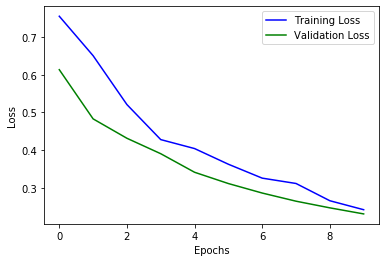

In [41]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

### Evaluating VGG16 on validation data

              precision    recall  f1-score   support

           0       0.94      0.85      0.89        54
           1       0.95      0.98      0.97       155

    accuracy                           0.95       209
   macro avg       0.94      0.92      0.93       209
weighted avg       0.95      0.95      0.95       209

************************************************************


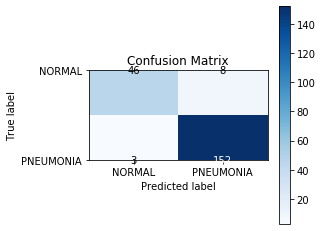

In [42]:
# Make a set of predictions for the test data
vgg16_pred_valid = np.argmax(vgg16_model.predict(X_valid_color), axis = 1)

# Print performance details
print(metrics.classification_report(y_valid_color_num, vgg16_pred_valid))
vgg16_pred_valid_acc = round(metrics.classification_report(y_valid_color_num,
                                                                vgg16_pred_valid,
                                                 output_dict=True)['accuracy'], 2)
print("*" * 60)
skplt.metrics.plot_confusion_matrix(list(map(lambda x: classes_num_label[x], y_valid_color_num)),
                                    list(map(lambda x: classes_num_label[x], vgg16_pred_valid)),
                                    figsize=(4,4))
plt.show()

The VGG16 model has an accuracy of 0.95 is good. <br />
Further, we observe that f1 score for Pneumonia is 0.97 and the score for Normal is also good at 0.89

# Task 6 - Performance Comparision

### 6.1 Evaluating Logistic Regression Model on test set

              precision    recall  f1-score   support

      NORMAL       1.00      0.28      0.44        46
   PNEUMONIA       0.70      1.00      0.83        78

    accuracy                           0.73       124
   macro avg       0.85      0.64      0.63       124
weighted avg       0.81      0.73      0.68       124

************************************************************


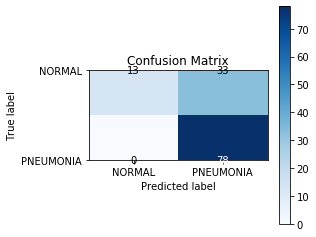

In [43]:
# Make a set of predictions for the test data
lr_pred_test = lr_model.predict(reshaped_X_test_gray)

# Print performance details
print(metrics.classification_report(y_test, lr_pred_test))

result = metrics.classification_report(y_test, lr_pred_test, output_dict=True)
lr_pred_test_acc = round(result['accuracy'], 2)
lr_pred_test_norm_prec = round(result['NORMAL']['precision'], 2)
lr_pred_test_norm_rec = round(result['NORMAL']['recall'], 2)
lr_pred_test_norm_f1 = round(result['NORMAL']['f1-score'], 2)
lr_pred_test_pneu_prec = round(result['PNEUMONIA']['precision'], 2)
lr_pred_test_pneu_rec = round(result['PNEUMONIA']['recall'], 2)
lr_pred_test_pneu_f1 = round(result['PNEUMONIA']['f1-score'], 2)

print("*" * 60)
skplt.metrics.plot_confusion_matrix( y_test, lr_pred_test, figsize=(4,4))
plt.show()

### 6.2 Evaluating LeNet-5 CNN Model on test dataset

              precision    recall  f1-score   support

           0       0.92      0.26      0.41        46
           1       0.69      0.99      0.81        78

    accuracy                           0.72       124
   macro avg       0.81      0.62      0.61       124
weighted avg       0.78      0.72      0.66       124

************************************************************


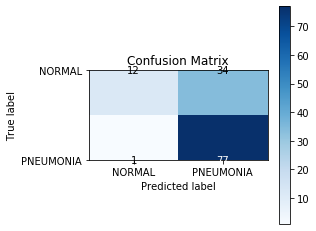

In [44]:
# Make a set of predictions for the test data
leNet5_pred_test = leNet5_model.predict_classes(X_test_gray)

# Print performance details
print(metrics.classification_report(y_test_num, leNet5_pred_test))

result = metrics.classification_report(y_test_num, leNet5_pred_test, output_dict=True)
leNet5_pred_test_acc = round(result['accuracy'], 2)
leNet5_pred_test_norm_prec = round(result['0']['precision'], 2)
leNet5_pred_test_norm_rec = round(result['0']['recall'], 2)
leNet5_pred_test_norm_f1 = round(result['0']['f1-score'], 2)
leNet5_pred_test_pneu_prec = round(result['1']['precision'], 2)
leNet5_pred_test_pneu_rec = round(result['1']['recall'], 2)
leNet5_pred_test_pneu_f1 = round(result['1']['f1-score'], 2)

print("*" * 60)
skplt.metrics.plot_confusion_matrix(list(map(lambda x: classes_num_label[x], y_test_num)),
                                    list(map(lambda x: classes_num_label[x], leNet5_pred_test)),
                                    figsize=(4,4))
plt.show()

### 6.3 Evaluating LeNet-5 CNN on undersampled data with test data

              precision    recall  f1-score   support

           0       0.88      0.46      0.60        46
           1       0.75      0.96      0.84        78

    accuracy                           0.77       124
   macro avg       0.81      0.71      0.72       124
weighted avg       0.80      0.77      0.75       124

************************************************************


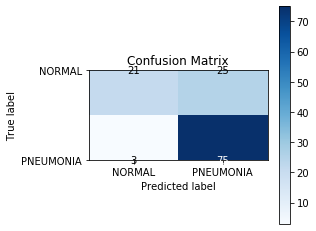

In [45]:
# Make a set of predictions for the test data
leNet5_model_undersamp_pred = leNet5_model_undersamp.predict_classes(X_test_gray)

# Print performance details
print(metrics.classification_report(y_test_num, leNet5_model_undersamp_pred))

result = metrics.classification_report(y_test_num, leNet5_model_undersamp_pred, output_dict=True)
leNet5_us_pred_test_acc = round(result['accuracy'], 2)
leNet5_us_pred_test_norm_prec = round(result['0']['precision'], 2)
leNet5_us_pred_test_norm_rec = round(result['0']['recall'], 2)
leNet5_us_pred_test_norm_f1 = round(result['0']['f1-score'], 2)
leNet5_us_pred_test_pneu_prec = round(result['1']['precision'], 2)
leNet5_us_pred_test_pneu_rec = round(result['1']['recall'], 2)
leNet5_us_pred_test_pneu_f1 = round(result['1']['f1-score'], 2)

print("*" * 60)
skplt.metrics.plot_confusion_matrix( list(map(lambda x: classes_num_label[x], y_test_num)),
                                    list(map(lambda x: classes_num_label[x], leNet5_model_undersamp_pred)),
                                    figsize=(4,4))
plt.show()

### 6. 4 Evaluating LeNet-5 CNN with data augumentation on test set

              precision    recall  f1-score   support

           0       0.68      0.61      0.64        46
           1       0.78      0.83      0.81        78

    accuracy                           0.75       124
   macro avg       0.73      0.72      0.73       124
weighted avg       0.75      0.75      0.75       124

************************************************************


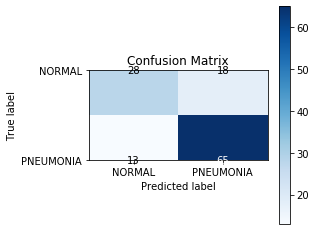

In [46]:
# Make a set of predictions for the test data
leNet5_pred_aug_test = leNet5_model_aug.predict_classes(X_test_gray)

# Print performance details
print(metrics.classification_report(y_test_num, leNet5_pred_aug_test))

result = metrics.classification_report(y_test_num, leNet5_pred_aug_test, output_dict=True)
leNet5_pred_aug_test_acc = round(result['accuracy'], 2)
leNet5_pred_aug_test_norm_prec = round(result['0']['precision'], 2)
leNet5_pred_aug_test_norm_rec = round(result['0']['recall'], 2)
leNet5_pred_aug_test_norm_f1 = round(result['0']['f1-score'], 2)
leNet5_pred_aug_test_pneu_prec = round(result['1']['precision'], 2)
leNet5_pred_aug_test_pneu_rec = round(result['1']['recall'], 2)
leNet5_pred_aug_test_pneu_f1 = round(result['1']['f1-score'], 2)

print("*" * 60)
skplt.metrics.plot_confusion_matrix(list(map(lambda x: classes_num_label[x], y_test_num)),
                                    list(map(lambda x: classes_num_label[x], leNet5_pred_aug_test)),
                                    figsize=(4,4))
plt.show()

### 6.5 Evaluating VGG16 on test data

              precision    recall  f1-score   support

           0       1.00      0.22      0.36        46
           1       0.68      1.00      0.81        78

    accuracy                           0.71       124
   macro avg       0.84      0.61      0.58       124
weighted avg       0.80      0.71      0.64       124

************************************************************


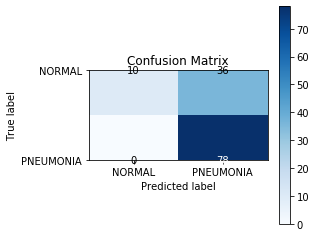

In [47]:
# Make a set of predictions for the test data
vgg16_pred_test = np.argmax(vgg16_model.predict(X_test_color), axis = 1)

# Print performance details
print(metrics.classification_report(y_test_num, vgg16_pred_test))

result = metrics.classification_report(y_test_num, vgg16_pred_test, output_dict=True)
vgg16_pred_test_acc = round(result['accuracy'], 2)
vgg16_pred_test_norm_prec = round(result['0']['precision'], 2)
vgg16_pred_test_norm_rec = round(result['0']['recall'], 2)
vgg16_pred_test_norm_f1 = round(result['0']['f1-score'], 2)
vgg16_pred_test_pneu_prec = round(result['1']['precision'], 2)
vgg16_pred_test_pneu_rec = round(result['1']['recall'], 2)
vgg16_pred_test_pneu_f1 = round(result['1']['f1-score'], 2)

print("*" * 60)
skplt.metrics.plot_confusion_matrix(list(map(lambda x: classes_num_label[x], y_test_num)),
                                    list(map(lambda x: classes_num_label[x], vgg16_pred_test)),
                                    figsize=(4,4))
plt.show()

### Validation accuracy vs Test accuracy 

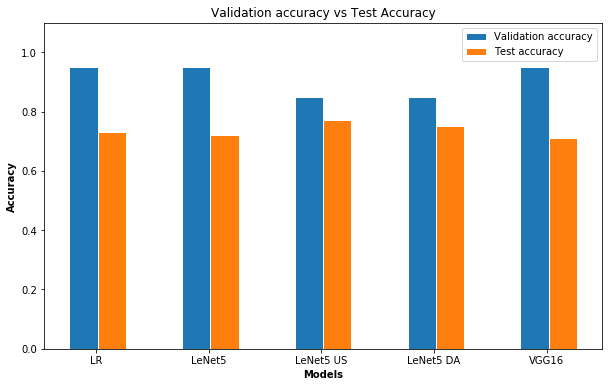

In [48]:
plt.figure(figsize=(10,6))

labels = ['LR', 'LeNet5', 'LeNet5 US', 'LeNet5 DA', 'VGG16']
val_acc = [lr_pred_valid_acc, leNet5_pred_valid_acc, leNet5_pred_aug_valid_acc, 
           leNet5_pred_aug_valid_acc, vgg16_pred_valid_acc]
test_acc = [lr_pred_test_acc, leNet5_pred_test_acc, leNet5_us_pred_test_acc,
            leNet5_pred_aug_test_acc, vgg16_pred_test_acc]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

r1 = np.arange(len(val_acc))
r2 = [x + width for x in r1]


# Make the plot
plt.bar(r1, val_acc, width=width, edgecolor='white', label='Validation accuracy')
plt.bar(r2, test_acc, width=width, edgecolor='white', label='Test accuracy')

axes = plt.gca()
axes.set_ylim([0,1.1])

# Add xticks on the middle of the group bars
plt.xlabel('Models', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.xticks([r + 0.11 for r in range(len(val_acc))], labels)
 
plt.title('Validation accuracy vs Test Accuracy')
# Create legend & Show graphic
plt.legend(bbox_to_anchor=(1, 1), loc='best')
plt.show()

The above graph we are comapring the validation and test accuracies across the five models that were built earlier.
Overall we can see that the validation accuracies for all models are better than that of test.
The highest validation accuracies is 0.95 which is achieved by Logistic Regression, Simple LeNet5 & VGG16 Models.
The model that performs best on test dataset is LeNet5 model with undersampled dataset.
<p>
    As the dataset is highly imbalanced, all models perform well in predicting pneumonia but not normal class and hence the accuracy goes down. But, after unsampling the model gets a chance to train equally on both the classes.
even it is seen that the LeNetModel with data augmentation achieves second best accuracy of 0.75. This is because the model was exposed to different variations of images which increased normal class data.
<p>
    Suprisingly, VGG16 did not achieve the expected accuracy as it is considered the best model in image classification. Due to computational restrictions, a smaller epoch size of 10 was used to find the best weights. This could be the reason for lower accuracy of VGG16 Model.
<p> 
    The Model that trained fastest was Logistic regression(LR) as the data was reshaped and it did not involve any neural networks. Further, the model that took the most computational time was VGG 16 as it involved a number of convolutional, activation and dense layers. Also, it was trained on color image data whereas all the other models were trained on grey image data.
   
    

## Performance comparison using precision, recall and f1-score

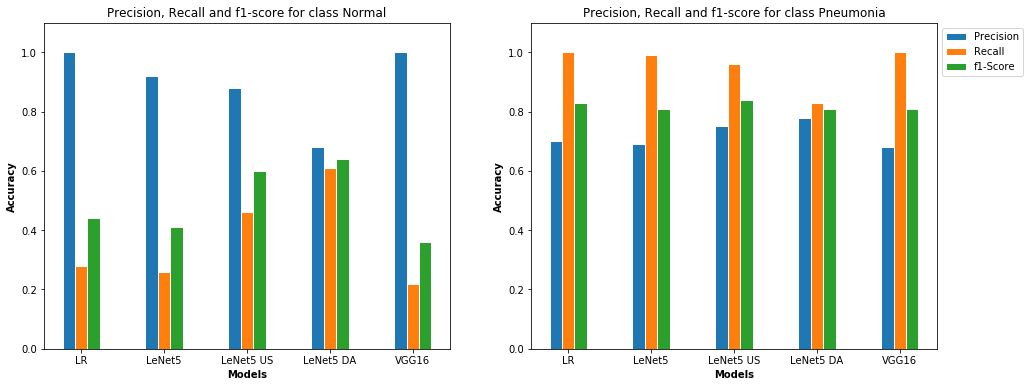

In [49]:
plt.figure(figsize=(16,6))


x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

r1 = np.arange(len(val_acc))
r2 = [x + width for x in r1]
r3 = [x + 2*width for x in r1]


plt.subplot(1, 2, 1)
labels = ['LR', 'LeNet5', 'LeNet5 US', 'LeNet5 DA', 'VGG16']
prec = [lr_pred_test_norm_prec, leNet5_pred_test_norm_prec, leNet5_us_pred_test_norm_prec,
       leNet5_pred_aug_test_norm_prec, vgg16_pred_test_norm_prec]
recall = [lr_pred_test_norm_rec, leNet5_pred_test_norm_rec, leNet5_us_pred_test_norm_rec,
         leNet5_pred_aug_test_norm_rec, vgg16_pred_test_norm_rec]
f1 = [lr_pred_test_norm_f1, leNet5_pred_test_norm_f1, leNet5_us_pred_test_norm_f1,
     leNet5_pred_aug_test_norm_f1, vgg16_pred_test_norm_f1]


# Make the plot
plt.bar(r1, prec, width=width, edgecolor='white', label='Precision')
plt.bar(r2, recall, width=width, edgecolor='white', label='Recall')
plt.bar(r3, f1, width=width, edgecolor='white', label='f1-Score')

axes = plt.gca()
axes.set_ylim([0,1.1])

# Add xticks on the middle of the group bars
plt.xlabel('Models', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.xticks([r + 0.15 for r in range(len(val_acc))], labels)
plt.title('Precision, Recall and f1-score for class Normal')



# 2nd plot
plt.subplot(1, 2, 2)
labels = ['LR', 'LeNet5', 'LeNet5 US', 'LeNet5 DA', 'VGG16']
prec = [lr_pred_test_pneu_prec, leNet5_pred_test_pneu_prec, leNet5_us_pred_test_pneu_prec,
       leNet5_pred_aug_test_pneu_prec, vgg16_pred_test_pneu_prec]
recall = [lr_pred_test_pneu_rec, leNet5_pred_test_pneu_rec, leNet5_us_pred_test_pneu_rec,
         leNet5_pred_aug_test_pneu_rec, vgg16_pred_test_pneu_rec]
f1 = [lr_pred_test_pneu_f1, leNet5_pred_test_pneu_f1, leNet5_us_pred_test_pneu_f1,
     leNet5_pred_aug_test_pneu_f1, vgg16_pred_test_pneu_f1]

# Make the plot
plt.bar(r1, prec, width=width, edgecolor='white', label='Precision')
plt.bar(r2, recall, width=width, edgecolor='white', label='Recall')
plt.bar(r3, f1, width=width, edgecolor='white', label='f1-Score')

axes = plt.gca()
axes.set_ylim([0,1.1])

# Add xticks on the middle of the group bars
plt.xlabel('Models', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.xticks([r + 0.15 for r in range(len(val_acc))], labels)
 
plt.title('Precision, Recall and f1-score for class Pneumonia')
# Create legend & Show graphic
plt.legend(bbox_to_anchor=(1, 1), loc='best')


plt.show()


The above graphs depict precision, recall and f1-score for the classes Normal and pneumonia. From the graph, We observe that for normal class the precision is high for all the models whereas recall and f1-score are quite low. This is because of the imbalance data. On the other hand, for class pneumonia the precision, recall & f1 score are good.
    

## Conclusion

Chest X-rays present a difficult classification task due to the relatively large amount of variable objects, specifically the imaged areas outside the lungs that are irrelevant to the diagnosis of pneumonia. The binary classification task for image require reshaping images to greyscale.Working with Logistic regression show promising results but feature engineering is to performed for it and incapable to find complex relationship among the features.
<p>
    On the other hand, Convolution neural networks show promising result on both validation and test data but requires computational overhead. With complex images and highly imbalance data set it performs decent and achieve lower precision on test dataset.
    
<p> 
    The data augmentation introduces the increase in data by zooming and shifting of image which improves performance attain precision to 0.75. The resulting high-accuracy model shows that it is efficient in learning the complicated images and perform very well on small dataset. ALso LeNet-DU performs well even on test dataset.
<p> 
    The VGG16 is pretrained model and its performance depends highly on the weights of the pre-trained model. However, we observe that the model has low f1-score as it could only use 20% of the full dataset. If more computational power and more images would have been used to train the model, they could have performed better.
    
<p> Overall, we can say that CNN and VGG16 models are very effective in image classification when trained on right parameters.